## DIGIT Force Calibration

### Overview

This notebook compares measurements collected across different objects, motions, and FSR placements, establishes thresholds for three discrete force levels, and calibrates voltage readings to Newtons. Together, these steps provide a reliable baseline for using an FSR mounted on the rear of a DIGIT tactile sensor.

During operation, the forefinger rests on the rear-mounted FSR to control the applied pressure, while the thumb and middle finger grip the sides of the DIGIT purely for stability. All cables are arranged so they remain clear of the workspace and do not interfere with data collection.

All measurements were taken in a standard home office environment at an average room temperature of approximately 20.5 °C.

### Imports and Useful Functions

In [123]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import confusion_matrix

In [124]:
def plot_voltage_over_time(df, column_name):
    """
    Plots the voltage over time for different values in the specified column.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to analyse.
    """
    # Extract possible values for the specified column
    vals = df[column_name].unique()

    # Create the figure
    plt.figure(figsize=(10, 6))

    # Plot the voltage for each value
    for val in vals:
        data = df[df[column_name] == val]
        sns.lineplot(data=data, x='time_s', y='voltage', label=val)
    
    # Labels and title
    plt.title('FSR Voltage Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.legend()
    plt.grid(True)

    # Save the plot
    plt.savefig(f'plots/{column_name}s.png', dpi=300, bbox_inches='tight')
    
    # Show plot
    plt.tight_layout()
    plt.show()

In [125]:
def plot_voltage_by_x(df, x, xlabel, save_name, type='box'):
    """
    Plots a boxplot or violin plot of voltage grouped by column x.

    Args:
        df (pd.DataFrame): The input DataFrame.
        x (str): The column name to group by on the x-axis.
        xlabel (str): The label for the x-axis.
        save_name (str): The name to save the plot as.
        type (str): Type of plot to create ('box' or 'violin').
    """
    # Create the figure
    plt.figure(figsize=(10, 6))

    # Plot based on the specified type
    if type == 'box':
        ax = sns.boxplot(
            data=df,
            x=x,
            y='voltage',
        )
    elif type == 'violin':
        ax = sns.violinplot(
            data=df,
            x=x,
            y='voltage',
            inner='quartile',  # Show median + quartiles inside the violin
            cut=0,  # Do not extend beyond min/max of data
        )
    
    # Labels and title
    ax.set_title('Voltage Distribution per ' + xlabel, fontsize=14, pad=15)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel('Voltage (V)', fontsize=12)
    
    # Save the plot
    plt.savefig(f'plots/{save_name}.png', dpi=300, bbox_inches='tight')

    # Show plot
    plt.tight_layout()
    plt.show()

In [126]:
def plot_calibration_curve(df, force_col='force_n', volt_col='voltage'):
    """
    Plots a calibration curve of voltage vs applied force.

    Args:
        df (pd.DataFrame): Calibration data.
        force_col (str): Column containing force values.
        volt_col (str): Column containing voltage values.
    """
    # Create the figure
    plt.figure(figsize=(10, 6))

    # Plot voltage vs force
    plt.plot(df[force_col], df[volt_col], marker='o', linestyle='-')

    # Labels and title
    plt.title('Calibration Curve')
    plt.xlabel('Force (N)')
    plt.ylabel('Voltage (V)')
    plt.grid(True)

    # Save the plot
    plt.savefig('plots/calibration_curve.png', dpi=300, bbox_inches='tight')
    
    # Show grid and plot
    plt.tight_layout()
    plt.show()

In [127]:
def threshold_cm(actual, classified, labels):
    """
    Plots a confusion matrix comparing actual vs classified force levels.

    Args:
        actual (list): List of actual force levels.
        classified (list): List of classified force levels.
        labels (list): List of force level labels.
    """
    # Build the confusion matrix
    cm = confusion_matrix(actual, classified, labels=labels)

    # Plot as heatmap
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels
    )

    # Labels and title
    plt.title('Confusion Matrix for Force-Level Thresholds')
    plt.xlabel('Classified Force Level')
    plt.ylabel('Actual Force Level')

    # Save the plot
    plt.savefig('plots/confusion_matrix.png', dpi=300, bbox_inches='tight')

    # Show plot
    plt.tight_layout()
    plt.show()

In [128]:
def remove_iqr_outliers(df, col, k=1.5):
    """
    Remove IQR outliers from a Pandas DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        col (str): Name of the column to check for outliers.
        k (float, optional): IQR multiplier used to define outlier thresholds.
            Defaults to 1.5.

    Returns:
        pandas.DataFrame: DataFrame with outliers removed based on the IQR rule.
    """
    # Calculate Q1, Q3, and IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier thresholds
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR

    # Keep only non-outliers
    return df[(df[col] >= lower) & (df[col] <= upper)]

### Object Comparison

I carried out a series of long-press tests with the DIGIT sensor on five different objects, recording both the raw FSR values and the converted voltages for two seconds at approximately 20 Hz. Each long press began with light contact before gradually increasing the applied force until reaching a full press. For all object trials, the sensor was held facing downwards to maintain a consistent pressing orientation.

In [129]:
# Load the CSV data
df_press = pd.read_csv('data/press_data.csv')
df_press.head()

,object,time_s,raw,voltage
0,beans,0.001,320,0.0161
1,beans,0.052,944,0.0475
2,beans,0.103,304,0.0153
3,beans,0.153,896,0.0451
4,beans,0.204,320,0.0161


Below, I plot the FSR voltage over time for each object to assess whether any visible differences emerge across objects.

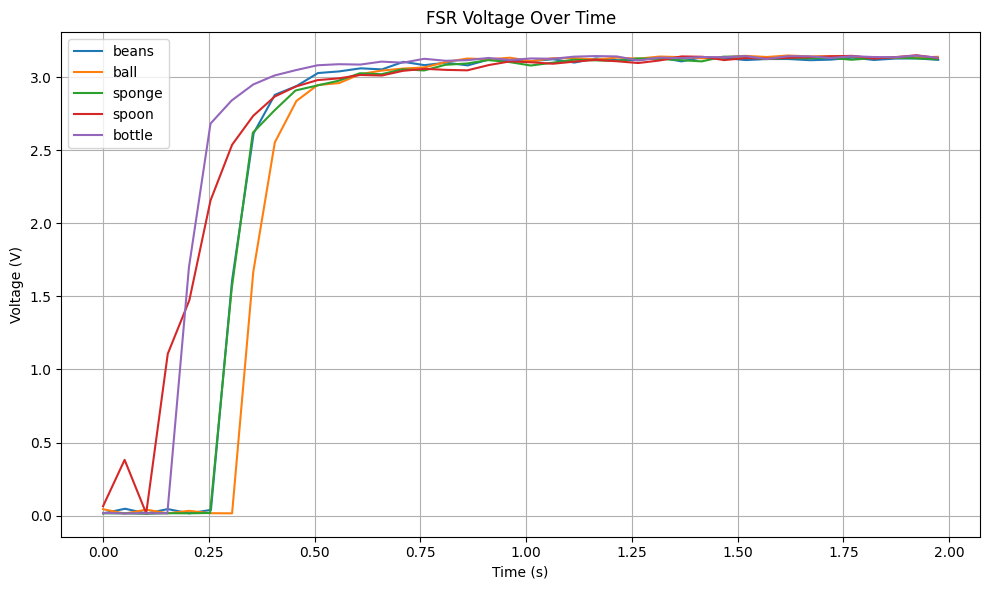

In [130]:
# Plot the curves for each object in the press data
plot_voltage_over_time(df_press, 'object')

The traces are broadly very similar across objects, with all reaching nearly the same steady-state voltage once fully pressed. Minor differences in the ramp-up phase, as well as the small spike at the start of one trial, are expected and likely due to normal human variation in the pressing motion. Overall, the steady-state output is consistent and largely object-independent.

### FSR Position Comparison

I carried out a series of long-press tests using the DIGIT sensor on a tennis ball, chosen for its uniform texture and geometry, to examine whether the FSR’s output varied with press orientation. The sensor was pressed firmly against the ball from three directions: vertically downward onto the top surface, horizontally into the right side, and upward into the underside. I held the ball in my other hand throughout to prevent any movement. In these trials I maintained the initial contact position slightly longer than in the object long-press tests to ensure that the early portion of the data was reliably captured.

In [131]:
# Load the CSV data
df_press_pos = pd.read_csv('data/press_position_data.csv')
df_press_pos.head()

,position,time_s,raw,voltage
0,top,0.000,272,0.0137
1,top,0.051,784,0.0395
2,top,0.102,320,0.0161
3,top,0.153,592,0.0298
4,top,0.204,208,0.0105


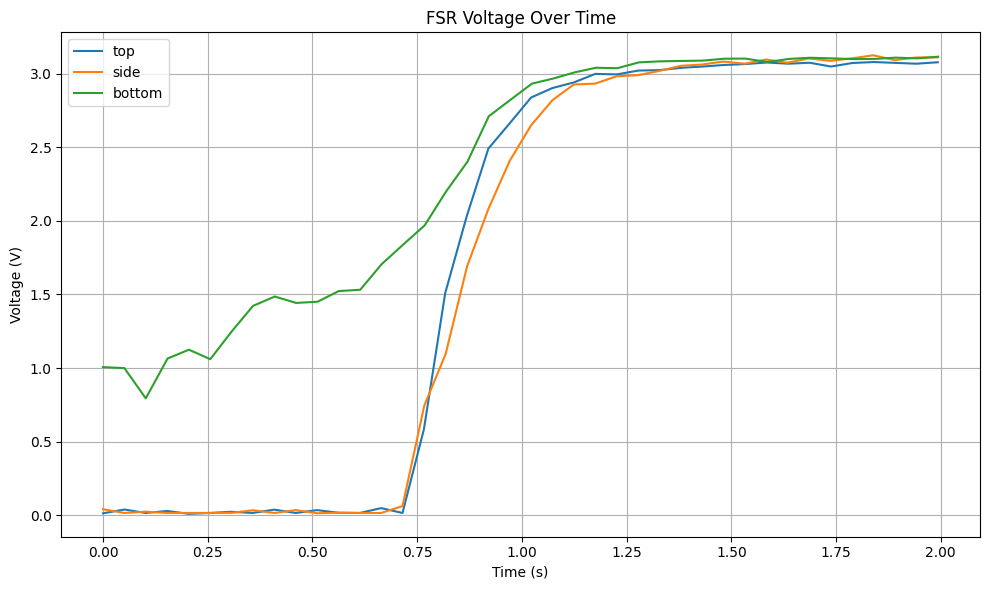

In [132]:
# Plot the curves for each position in the press position data
plot_voltage_over_time(df_press_pos, 'position')

The plot shows that the voltage profiles for the top and side orientations are almost identical across the entire two-second press. Both produce the same near-zero baseline, similar force-increase trajectories, and comparable saturation values. In contrast, the bottom orientation begins at a noticeably higher voltage before the press starts. This elevated baseline is likely caused by the weight of the DIGIT sensor resting on the FSR when the sensor is facing upwards, resulting in an initial pre-load that does not occur in the other orientations.

Because this pre-load artificially shifts the voltage values and does not reflect the intended force-application behaviour, future data collection will be limited to downward and sideways orientations, including intermediate angles between them.

### Force Level Thresholds

I collected FSR readings by performing sliding and rotational motions across five different objects under three manually applied force conditions. Level 1 involved making contact with the object without exerting pressure, Level 2 introduced light pressure resulting in slight deformation, and Level 3 applied firm pressure, producing marked deformation while remaining within safe limits for both the sensor and the object.  

Both sliding and rotational motions were included because these will be used in the final dataset, and it was necessary to ensure that the force readings remained consistent across the two movement types.

The aim was to record both raw and converted voltage readings in order to gauge suitable thresholds for the three discrete force levels.

In [133]:
# Load the CSV data
df_motion = pd.read_csv('data/motion_data.csv')
df_motion.head()

,object,motion,force,raw,voltage
0,beans,slide,1,336,0.0169
1,beans,slide,1,464,0.0234
2,beans,slide,1,320,0.0161
3,beans,slide,1,256,0.0129
4,beans,slide,1,336,0.0169


In [134]:
# Initial stats
force_stats = df_motion.groupby('force')['voltage'].describe()
force_stats

,count,mean,std,min,25%,50%,75%,max
force,,,,,,,,
1,500.0,0.022411,0.010863,0.0073,0.0161,0.0169,0.0290,0.0540
2,500.0,2.599554,0.552760,0.0161,2.6104,2.7859,2.9064,3.0107
3,500.0,3.054284,0.053176,2.5828,3.0357,3.0574,3.0792,3.1373


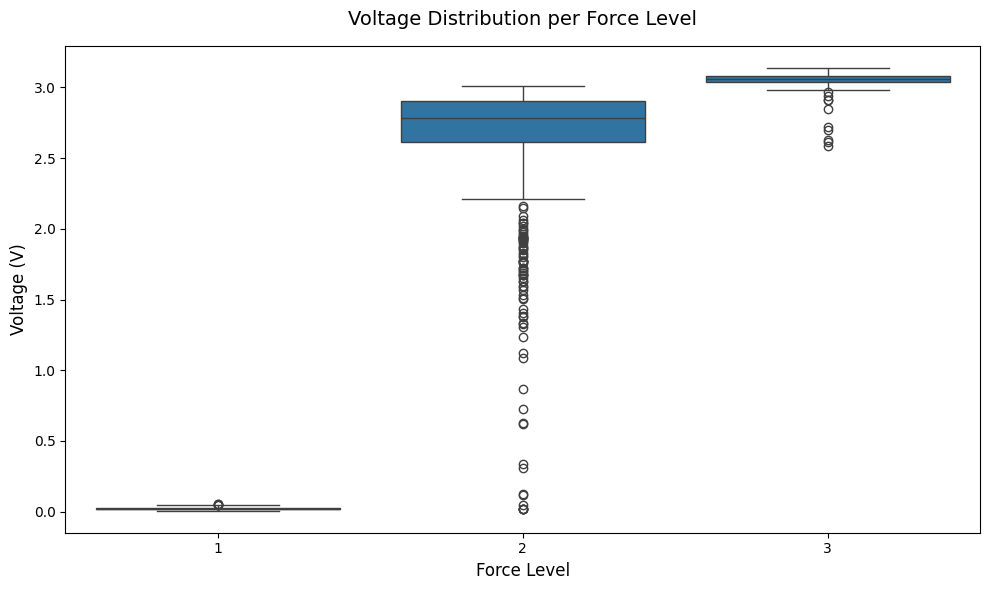

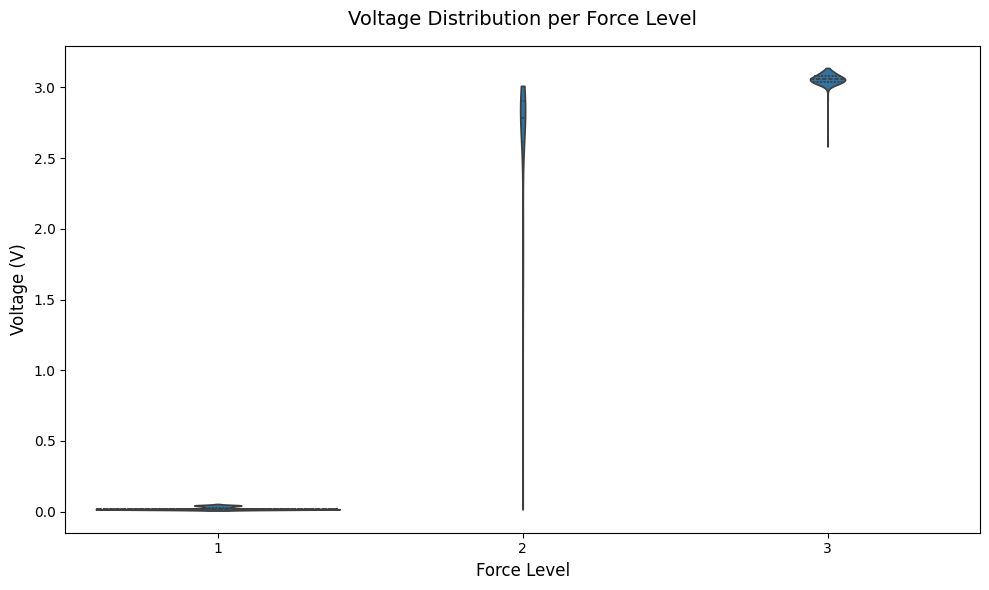

In [135]:
# Show boxplot and violin plots for the data
plot_voltage_by_x(df_motion, x='force', xlabel='Force Level', save_name='force_boxplot', type='box')
plot_voltage_by_x(df_motion, x='force', xlabel='Force Level', save_name='force_violinplot', type='violin')

In [136]:
# Remove outliers from motion data
df_motion_clean = (
    df_motion
    .groupby('force', group_keys=False)
    .apply(remove_iqr_outliers, col='voltage', k=1.5)
)
 
df_motion_clean['force'].value_counts().sort_index()

/var/folders/wp/c8l2zvtj0s74nmvn23mcmxnw0000gn/T/ipykernel_34261/3321826010.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(remove_iqr_outliers, col='voltage', k=1.5)


force
1    495
2    425
3    490
Name: count, dtype: int64

In [137]:
# Cleaned stats
force_stats_clean = df_motion_clean.groupby('force')['voltage'].describe()
force_stats_clean

,count,mean,std,min,25%,50%,75%,max
force,,,,,,,,
1,495.0,0.022124,0.010533,0.0073,0.0161,0.0169,0.0270,0.0483
2,425.0,2.799248,0.152900,2.2089,2.7166,2.8391,2.9140,3.0107
3,490.0,3.059829,0.030580,2.9785,3.0367,3.0582,3.0812,3.1373


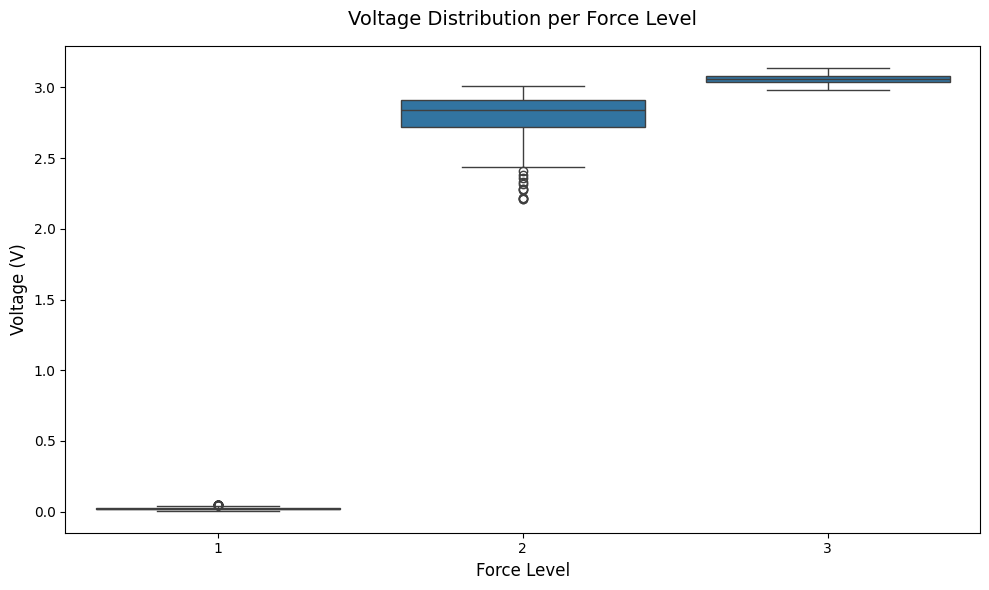

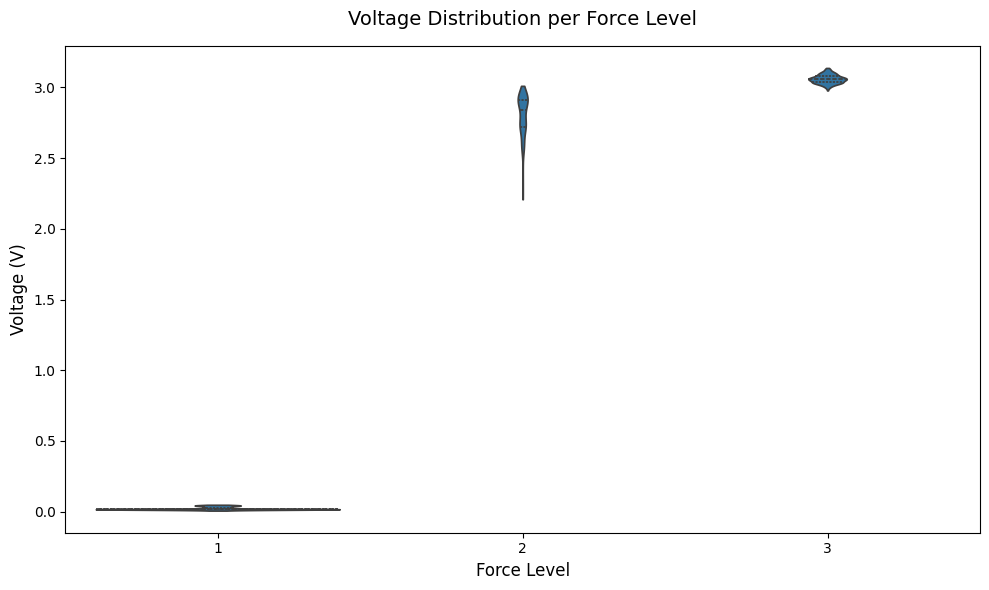

In [138]:
# Show boxplot and violin plots for the cleaned data
plot_voltage_by_x(df_motion_clean, x='force', xlabel='Force Level', save_name='force_boxplot_clean', type='box')
plot_voltage_by_x(df_motion_clean, x='force', xlabel='Force Level', save_name='force_violinplot_clean', type='violin')

To support the visual and statistical analysis above, the following table summarises the final force-level voltage thresholds that will be used for classification.

| Force Level | Voltage Range (V) |
| ----------- | ----------------- |
| **Level 1** | 0.00 ≤ V < 0.99   |
| **Level 2** | 0.99 ≤ V < 2.99   |
| **Level 3** | V ≥ 2.99          |


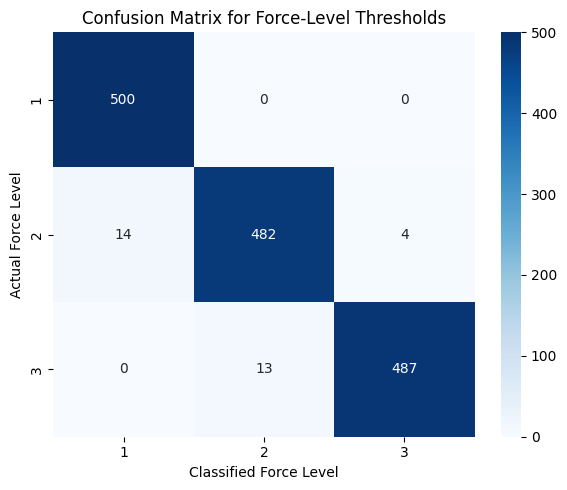

In [139]:
# Force-level thresholds
def classify_thresholds(v):
    """
    Classify voltage into force levels based on thresholds.

    Args:
        v (float): The voltage value.
    
    Returns:
        int: The classified force level (1, 2, or 3).
    """
    if v < 0.99:
        return 1
    elif v < 2.99:
        return 2
    else:
        return 3

# Classify based on thresholds
df_motion['classified'] = df_motion['voltage'].apply(classify_thresholds)

# Confusion matrix
threshold_cm(df_motion['force'], df_motion['classified'], labels=[1,2,3])

In [140]:
# Overall accuracy
overall_acc = (df_motion['classified'] == df_motion['force']).sum() / len(df_motion)
print(f'Overall accuracy: {overall_acc:.2f}%')

# Per-class accuracy
per_class_acc = df_motion.groupby('force').apply(
    lambda g: (g['classified'] == g['force']).sum() / len(g)
)

print('\nAccuracy per force level:')
print(per_class_acc)

Overall accuracy: 0.98%

Accuracy per force level:
force
1    1.000
2    0.964
3    0.974
dtype: float64


/var/folders/wp/c8l2zvtj0s74nmvn23mcmxnw0000gn/T/ipykernel_34261/3080034325.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_class_acc = df_motion.groupby('force').apply(


### Voltage to Newtons Calibration

To obtain an approximate force value in Newtons from the FSR readings, a calibration curve is required. All measurements were taken with the sensor placed centrally on the scales and with its cables positioned so they did not touch or interfere with the setup. I collected calibration data by pressing the sensor onto the scales at a series of known target weights. The lowest weight used was 25 g to account for the sensor’s own resting load, and all measurements were taken with the scales tared to zero beforehand.

For each target weight, multiple readings were recorded and the median voltage was used to provide a stable representative value that reduces the influence of noise or brief fluctuations.

The target masses are converted from grams to Newtons using the standard formula:

$$F = m g$$

where *m* is the mass in kilograms and $g = 9.81\,\text{m/s}^2$. The resulting force values are then plotted against the corresponding FSR voltages. To produce a practical voltage-to-force mapping, I use piecewise-linear interpolation based on these median calibration points, giving a stable and monotonic approximation across the usable range of the sensor.

In [141]:
# Load the CSV data
df_cal = pd.read_csv('data/force_calibration.csv')
df_cal.head()

,trial,target_g,time_s,raw,voltage
0,1,25,0.000,288,0.0145
1,1,25,0.080,336,0.0169
2,1,25,0.132,256,0.0129
3,1,25,0.184,416,0.0209
4,1,25,0.235,320,0.0161


In [142]:
# Initial stats
cal_stats = df_cal.groupby('target_g')['voltage'].describe()
cal_stats

,count,mean,std,min,25%,50%,75%,max
target_g,,,,,,,,
25,174.0,0.021839,0.009987,0.0000,0.0161,0.0169,0.0258,0.0709
50,173.0,0.022058,0.009613,0.0073,0.0161,0.0169,0.0274,0.0628
75,174.0,0.021240,0.009144,0.0064,0.0161,0.0161,0.0242,0.0516
100,174.0,0.020789,0.009750,0.0048,0.0161,0.0161,0.0248,0.0612
150,173.0,1.807555,0.114880,1.5867,1.7197,1.7705,1.9035,2.0711
200,173.0,2.204767,0.074920,2.0195,2.1372,2.2209,2.2734,2.3120
250,174.0,2.517036,0.039427,2.3854,2.5014,2.5312,2.5425,2.5755
300,173.0,2.717701,0.021882,2.6497,2.7021,2.7190,2.7351,2.7891
350,173.0,2.771136,0.026717,2.7182,2.7504,2.7690,2.7931,2.8246


In [143]:
# Convert target grams to force in Newtons
df_cal['force_n'] = df_cal['target_g'] * 9.81 / 1000.0
df_cal.head()

,trial,target_g,time_s,raw,voltage,force_n
0,1,25,0.000,288,0.0145,0.24525
1,1,25,0.080,336,0.0169,0.24525
2,1,25,0.132,256,0.0129,0.24525
3,1,25,0.184,416,0.0209,0.24525
4,1,25,0.235,320,0.0161,0.24525


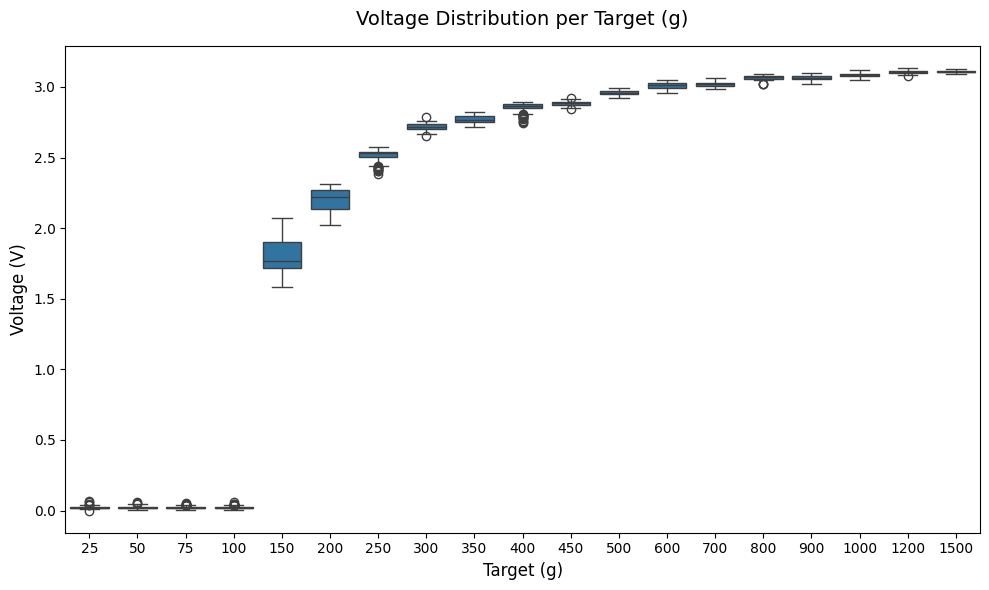

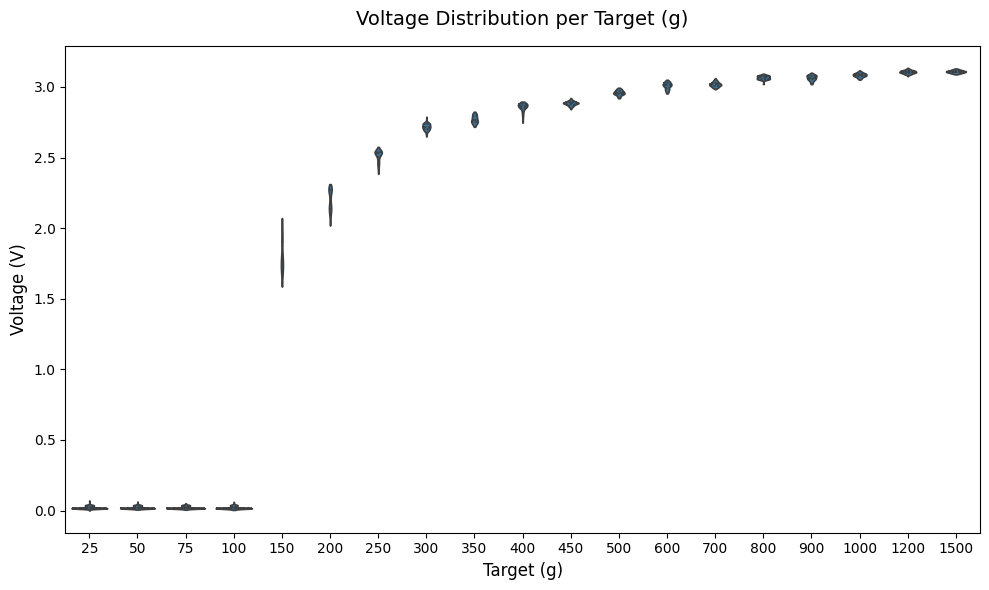

In [144]:
# Show boxplot and violin plots for the data
plot_voltage_by_x(df_cal, x='target_g', xlabel='Target (g)', save_name='calibration_boxplot', type='box')
plot_voltage_by_x(df_cal, x='target_g', xlabel='Target (g)', save_name='calibration_violinplot', type='violin')

In [145]:
# Remove outliers from calibration data
df_cal_clean = (
    df_cal
    .groupby('target_g', group_keys=False)
    .apply(remove_iqr_outliers, col='voltage', k=1.5)
)

df_cal_clean['target_g'].value_counts().sort_index()

/var/folders/wp/c8l2zvtj0s74nmvn23mcmxnw0000gn/T/ipykernel_34261/4139901295.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(remove_iqr_outliers, col='voltage', k=1.5)


target_g
25      168
50      170
75      151
100     156
150     173
200     173
250     163
300     171
350     173
400     161
450     172
500     174
600     173
700     174
800     171
900     173
1000    174
1200    173
1500    174
Name: count, dtype: int64

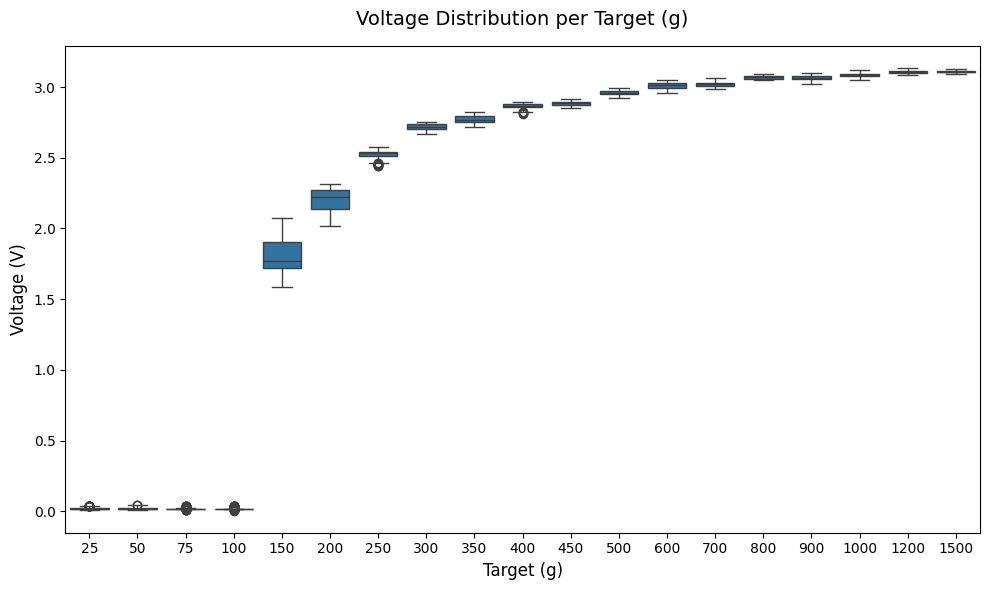

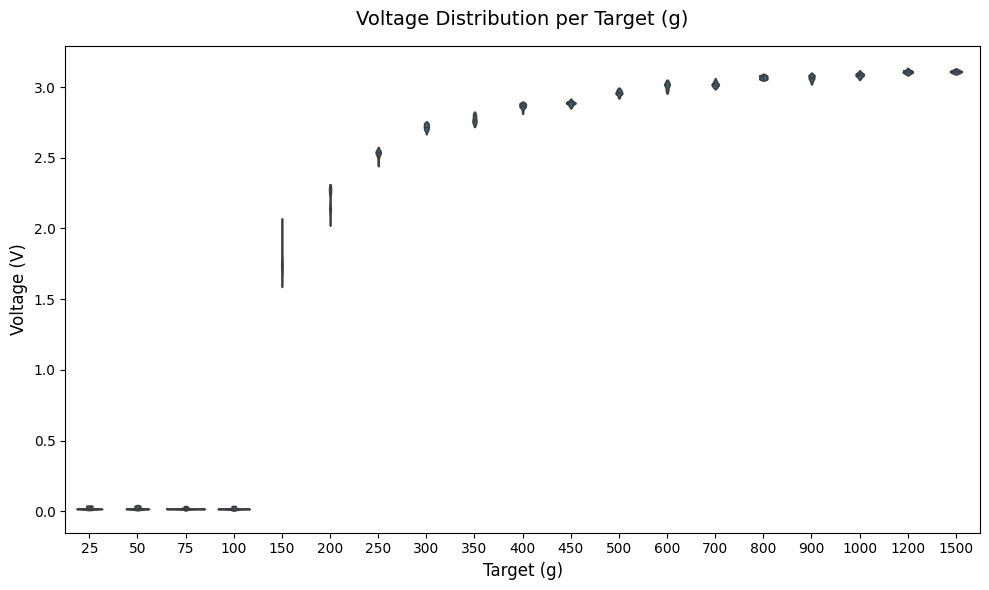

In [146]:
# Show boxplot and violin plots for the cleaned data
plot_voltage_by_x(df_cal_clean, x='target_g', xlabel='Target (g)', save_name='calibration_boxplot_clean', type='box')
plot_voltage_by_x(df_cal_clean, x='target_g', xlabel='Target (g)', save_name='calibration_violinplot_clean', type='violin')

In [147]:
# Get the median voltage for each force level
cal_curve_data = (
    df_cal_clean.groupby('force_n')['voltage']
    .median()
    .reset_index()
)
cal_curve_data

,force_n,voltage
0,0.24525,0.0169
1,0.49050,0.0169
2,0.73575,0.0161
3,0.98100,0.0161
4,1.47150,1.7705
5,1.96200,2.2209
6,2.45250,2.5328
7,2.94300,2.7190
8,3.43350,2.7690
9,3.92400,2.8673


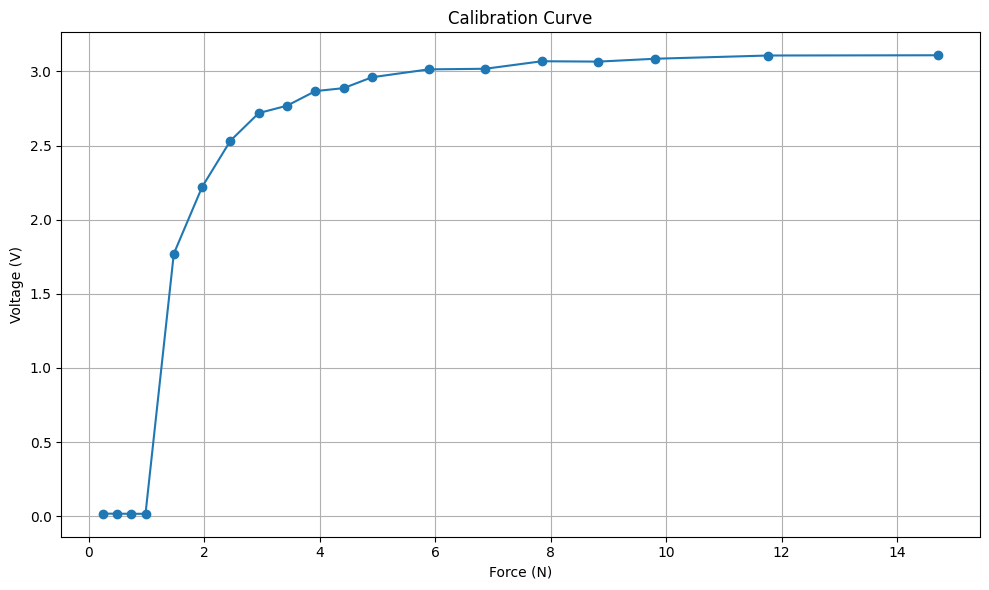

In [148]:
plot_calibration_curve(cal_curve_data)

In [149]:
# Sort by voltage to ensure monotonic interpolation
cal_curve_data = cal_curve_data.sort_values('voltage')

# Get voltage and force points for interpolation
volt_points  = cal_curve_data['voltage'].values
force_points = cal_curve_data['force_n'].values
def voltage_to_force(v):
    """
    Convert FSR voltage to force in Newtons using piecewise-linear interpolation
    from the calibration data.

    Args:
        v (float or np.ndarray or pd.Series): Measured voltage(s).
    
    Returns:
        np.ndarray: Corresponding force values in Newtons.
    """
    # Convert input to NumPy array
    v_arr = np.asarray(v, dtype=float)

    # Interpolate to get force values
    return np.interp(v_arr, volt_points, force_points,
                  left=0.0,  # Anything below the lowest calibrated voltage = 0 N (contact/no load)
                  right=force_points[-1])  # Anything above the highest voltage = max calibrated force

In [150]:
# Get thresholds in Newtons
thresholds_n = voltage_to_force([0.99, 2.99])
thresholds_n

array([1.03487221, 5.44445763])

The following table shows the converted Newton values for the three discrete thresholds.

| Force Level | Voltage Range (V) | Newton Range (N) |
|-------------|--------------------|------------------|
| **Level 1** | 0.00 ≤ V < 0.99    | 0 ≤ N < 1.035    |
| **Level 2** | 0.99 ≤ V < 2.99    | 1.035 ≤ N < 5.444|
| **Level 3** | V ≥ 2.99           | N ≥ 5.444        |
